In [2]:
import os,numpy as np, matplotlib.pyplot as plt,pandas as pd

In [3]:
import torch.optim as optim
import torch
from torch.autograd import Variable
import time
import torch
import torch.nn as nn
# from torchvision import datasets, transforms
from torchsummary import summary
import numpy as np
from HeartCepTorch import MFCC_Gen,Network
import torch.nn.functional as F
import torch.nn.init as init
from torchsummary import summary
def to_numpy(x):
    return x.cpu().detach().numpy()

In [17]:
model = Network(2,0)
mfcc_gen = MFCC_Gen(fs=1000,filters=64)

In [18]:
class WHOLE_MODEL(nn.Module):
    def __init__(self,kernel_size = 81,filters = 26,fs=1000,winlen=0.025,winstep=0.01,dimension=1):
        super(WHOLE_MODEL,self).__init__()
        self.mfcc = MFCC_Gen(fs=1000,filters=64)
        self.classifier = Network(2,0)
        for x in self.mfcc.gamma.named_parameters():
            x[1].requires_grad = True
    def forward(self,x):
        x = self.mfcc(x)
        x = x.transpose(2,1)
        x = x.unsqueeze(1)
        x = self.classifier(x)
        return x

In [27]:
model = WHOLE_MODEL()

In [8]:
path = "../../Heartnet_Results/logs/gammatone_torch_layer/"
fold = 'a_bcdEf learnable_2020-03-04 17.19.23.260152'

In [14]:
weight = sorted(os.listdir(os.path.join(path,fold,'weights')))[-1]

In [29]:
model.load_state_dict(torch.load(os.path.join(path,fold,'weights',weight)))

<All keys matched successfully>

In [36]:
int(weight.split('-',maxsplit=1)[0].split('.')[-1])

154

In [1]:
fc = mfcc_gen.gamma.fc

NameError: name 'mfcc_gen' is not defined

In [31]:
optimizer = optim.Adam(model.parameters(), lr= .01)
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.CrossEntropyLoss()
start_epoch = 0
lr_schedule = optim.lr_scheduler.ExponentialLR(optimizer,0.986)
# wow= []
# for i in range(400):
#     optimizer.step()
#     wow.append(optimizer.param_groups[0]['lr'])
#     sh.step()
# plt.plot(wow)
# print(wow[-1])

In [43]:
model.cuda()
model.train()
for i in range(100):
    optimizer.zero_grad()
    loss = torch.from_numpy(np.array(100.198).astype(np.float32)).cuda()
    loss.requires_grad = True
    loss.backward()
    optimizer.step()

In [2]:
import whole_new_model,importlib
whole_new_model = importlib.reload(whole_new_model)
from whole_new_model import WHOLE_NEW_MODEL

In [4]:
model = WHOLE_NEW_MODEL()

In [5]:
summary(model.cuda(),(1,2500))

OK
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2420]           5,312
       BatchNorm1d-2             [-1, 64, 2420]             192
            Conv1d-3              [-1, 64, 240]         102,400
       BatchNorm1d-4              [-1, 64, 240]             192
            Conv2d-5          [-1, 16, 244, 65]             128
       BatchNorm2d-6          [-1, 16, 244, 65]              48
            Conv2d-7          [-1, 32, 242, 63]           4,672
       BatchNorm2d-8          [-1, 32, 242, 63]              96
         Dropout2d-9          [-1, 32, 242, 63]               0
           Conv2d-10          [-1, 32, 244, 65]           9,280
      BatchNorm2d-11          [-1, 32, 244, 65]              96
        Dropout2d-12          [-1, 32, 244, 65]               0
           Conv2d-13          [-1, 64, 122, 32]          18,560
      BatchNorm2d-14          [-1, 6

In [3]:
from torch.nn.parameter import Parameter
from HeartCepTorch import Conv_Gammatone_coeff
class Branch(nn.Module):
    def __init__(self,c_in, c_out, kernel_size=5,stride=1,dropout = 0.5):
        super(Branch, self).__init__()
        self.conv1 = nn.Conv1d(c_in, c_out*2, kernel_size=kernel_size,stride=stride)
        self.bn1 = nn.BatchNorm1d(c_out*2)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(c_out*2, c_out, kernel_size=kernel_size,stride=stride)
        self.bn2 = nn.BatchNorm1d(c_out)
        self.pool = nn.MaxPool1d(2)
    def forward(self, x):
        x = self.drop(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(x)
        x = self.drop(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(x)
        return x
class Net(nn.Module):
    def __init__(self,filters=64,kernel_size=81,fs=1000):
        super(Net,self).__init__()
        wow = Conv_Gammatone_coeff(1,filters,kernel_size,fs)
        self.filterbank = nn.ModuleList()
        for i in range(filters):
            conv = nn.Conv1d(1,1,kernel_size=kernel_size)
            conv.weight = Parameter(wow.weight[i:i+1])
            self.filterbank.append(conv)
        self.branches = nn.ModuleList()
        for i in range(filters):
            branch = Branch(1,4)
            self.branches.append(branch)
        self.dense = nn.Linear(4*602*filters,20)
        self.cls = nn.Linear(20,2)
        self.relu = nn.ReLU()
        self.soft = nn.Softmax()
    def forward(self,x):
        x = [c(x) for c in self.filterbank]
        x = [c(xx) for (xx,c) in zip(x,self.branches)]
        x = torch.cat(x,dim=1)
        x = x.view(x.size(0),-1)
        x = self.relu(self.dense(x))
        x = self.soft(self.cls(x))
        return x
model = Net()

In [ ]:
# from torchviz import make_dot

# out = model(torch.randn(1,1,2500).cuda())
# make_dot(out,params = dict(model.named_parameters()))

In [ ]:
summary(model.cuda(), (1,2500))

In [14]:
path_learned_from_heartnet = '/media/mhealthra2/Data/heart_sound/Heartnet_Results/logs/gammatone_torch_layer/fold0_noFIR dbt 64 HNET_2020-05-17 17.56.06.569274/weights/'
index_of_best_epoch = 5
weights = os.listdir(path)
len(weights)

74

In [26]:
key = "filterbank.{0}.weight"

In [28]:
wow['filterbank.0.weight']

tensor([[[ 0.0252,  0.0252,  0.0162,  0.0122,  0.0136,  0.0125,  0.0211,
           0.0261,  0.0185,  0.0155,  0.0204,  0.0192,  0.0167,  0.0153,
           0.0087,  0.0073,  0.0056,  0.0007, -0.0059, -0.0097, -0.0126,
          -0.0217, -0.0205, -0.0156, -0.0168, -0.0107, -0.0061, -0.0089,
          -0.0099, -0.0099, -0.0069, -0.0064, -0.0092, -0.0016,  0.0052,
           0.0047,  0.0040,  0.0060,  0.0150,  0.0198,  0.0092,  0.0015,
           0.0045, -0.0002, -0.0067, -0.0050, -0.0099, -0.0138, -0.0015,
           0.0016, -0.0163, -0.0122,  0.0058, -0.0077, -0.0193, -0.0062,
          -0.0057, -0.0189, -0.0207, -0.0075, -0.0017, -0.0063, -0.0039,
           0.0029,  0.0008,  0.0049,  0.0133,  0.0122,  0.0124,  0.0172,
           0.0154,  0.0120,  0.0155,  0.0300,  0.0364,  0.0304,  0.0319,
           0.0417,  0.0352,  0.0099,  0.0048]]], device='cuda:0')

weights.0053-acc_0.7331-macc_0.8059.pt


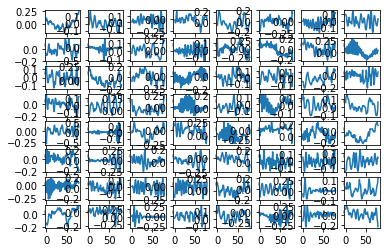

In [43]:
idx = 53
print(weights[idx])
model.load_state_dict(torch.load(path+weights[idx]))
for i in range(64):
#     plt.figure(figsize=(5,5))
    w = model.filterbank[i].weight  
    plt.subplot(8,8,i+1)
    plt.plot(to_numpy(w).squeeze().squeeze())

In [49]:
path = '/media/mhealthra2/Data/heart_sound/Heartnet_Results/logs/gammatone_torch_layer/fold0_noFIR dbt 64 HNET_2020-05-17 17.56.06.569274/weights/'
weights = os.listdir(path)
wow = dict(torch.load(path+weights[53]))
gamma_weight = torch.cat([wow['filterbank.{}.weight'.format(i)] for i in range(64)])
    

In [13]:
path = '../../Heartnet_Results/logs/gammatone_torch_layer/fold0_noFIR requires grad on_2020-06-24 16.40.50.366772/weights/weights.0004-acc_0.7225-macc_0.7581.pt'
best = 'weights.0072-acc_0.7559-macc_0.8168.pt'
initial = 'weights.0001-acc_0.5766-macc_0.5292.pt'
wd = (torch.load(path))

tensor([[ 4.6416e-01,  2.6888e-01,  1.5619e-02, -6.4591e-02, -5.8536e-02,
          4.1355e-02,  1.7982e-01,  1.4256e-01,  3.8773e-02,  8.1064e-02,
          1.5755e-01,  1.0795e-01,  1.8719e-02,  1.7664e-04,  6.2533e-05,
          4.2842e-02,  1.3846e-01,  1.0516e-01, -3.3780e-02, -3.1651e-03,
          1.2390e-01,  3.4002e-02, -9.4312e-02, -9.8826e-03,  1.5923e-01,
          2.3663e-01,  1.6220e-01,  5.6168e-02, -1.2544e-02, -1.4162e-01,
         -2.5506e-01, -1.6600e-01,  1.1931e-01,  3.0070e-01,  2.4913e-01,
          2.0677e-01,  1.7311e-01, -3.8914e-02, -2.0911e-01, -1.1904e-01,
          3.1385e-02,  4.4835e-02,  4.2908e-02,  1.2551e-01,  1.4031e-01,
          3.7350e-02,  2.0649e-02,  1.3256e-01,  1.9541e-01,  1.5695e-01,
          1.0387e-01,  6.4968e-02,  2.6782e-02,  2.9964e-02,  3.9589e-02,
          4.2476e-02,  9.9733e-02,  1.4695e-01,  1.3711e-01,  9.0217e-02,
          1.9998e-02,  5.7321e-03,  2.5572e-02, -4.0752e-02, -5.1475e-02,
          6.4515e-02,  7.6396e-02, -5.

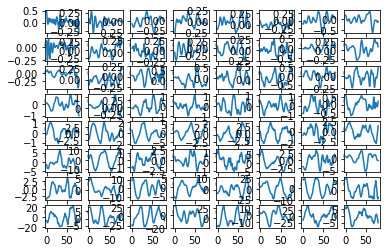

In [10]:
for i in range(64):
#     plt.figure(figsize=(5,5))
    w = wd[i,:]
    plt.subplot(8,8,i+1)
    plt.plot(to_numpy(w).squeeze().squeeze())
print(wd[0,:])

tensor([0.0000e+00, 5.3349e-06, 2.2769e-05, 4.0996e-05, 5.1842e-05, 5.4017e-05,
        4.9797e-05, 4.2186e-05, 3.3594e-05, 2.5518e-05, 1.8674e-05, 1.3260e-05,
        9.1842e-06, 6.2295e-06, 4.1508e-06, 2.7236e-06, 1.7634e-06, 1.1284e-06,
        7.1460e-07, 4.4836e-07, 2.7899e-07, 1.7230e-07, 1.0568e-07, 6.4425e-08,
        3.9051e-08, 2.3547e-08, 1.4131e-08, 8.4423e-09, 5.0230e-09, 2.9772e-09,
        1.7584e-09, 1.0350e-09, 6.0735e-10, 3.5535e-10, 2.0734e-10, 1.2066e-10,
        7.0048e-11, 4.0571e-11, 2.3447e-11, 1.3523e-11, 7.7834e-12, 4.4716e-12,
        2.5644e-12, 1.4681e-12, 8.3916e-13, 4.7891e-13, 2.7290e-13, 1.5529e-13,
        8.8249e-14, 5.0084e-14, 2.8389e-14, 1.6072e-14, 9.0886e-15, 5.1338e-15,
        2.8968e-15, 1.6329e-15, 9.1949e-16, 5.1729e-16, 2.9075e-16, 1.6327e-16,
        9.1609e-17, 5.1357e-17, 2.8768e-17, 1.6102e-17, 9.0058e-18, 5.0332e-18,
        2.8110e-18, 1.5688e-18, 8.7500e-19, 4.8770e-19, 2.7166e-19, 1.5123e-19,
        8.4135e-20, 4.6781e-20, 2.5997e-

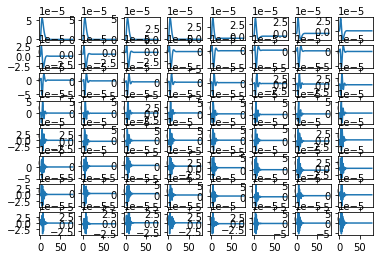

In [37]:
for i in range(64):
#     plt.figure(figsize=(5,5))
    w = wd[i,:]
    plt.subplot(8,8,i+1)
    plt.plot(to_numpy(w).squeeze().squeeze())
print(wd[0,:])

In [2]:
os.listdir('../../Heartnet_Results/logs/gammatone_torch_layer/fold0_noFIR dbt 64 learned from Hnet updated_2020-06-19 11.19.59.140554/weights/')

NameError: name 'os' is not defined

In [9]:
path = '../../Heartnet_Results/logs/gammatone_torch_layer/JUST TESTING FREEZED from 88%_2020-08-25 06.20.36.233551'
a = torch.load(path+"/weights/"+os.listdir(path+"/weights/")[0])

In [7]:
os.listdir('../../Heartnet_Results/logs/gammatone_torch_layer/JUST TESTING FREEZED from 88%_2020-08-25 06.20.36.233551')

['weights', 'training.csv']

In [ ]:
print("adsfsd")